# Autoencoder

 A CCN based autoencoder.

 Steps:

 1. build an autoencoder
 2. cluster code

## Load dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None, names=range(750))
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label"])

    return data, labels

In [4]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [5]:
X_df_reference, y_df_reference = load_dataset()

In [6]:
print_stats(X_df_reference)
print_stats(y_df_reference)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')


## Preprocessing

In [7]:
def get_label(x):
    return x[2]

In [8]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [9]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

Preoprocess the dataset with the following steps:

1. From pandas dataframe to numpy arrays
2. Restructure plain data vector from (750,) to (6,125) where first 3 vectors are accelerometer's x, y, z components while second 3 vectors are gyroscope's x, y, z components
3. Merge labels if needed
4. Normalize data
5. Split the dataset in train and test set
6. Disregard useless informations in y

In [10]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

In [11]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
but_last_user_indicies = y_df['user'] < "h"

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 17478
X_test_df = 5111
y_train_df = 17478
y_test_df = 5111


In [12]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()
X_train_oit = orientation_independent_transformation(np.reshape(X_train, (-1, 6, 125)))
X_test_oit = orientation_independent_transformation(np.reshape(X_test, (-1, 6, 125)))

y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()


# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
# NB: we do not normalize beacause the distance between points and reconstructed points
# is reduced but the signal is not well represented
#X_train = normalize(X_train)
#X_test = normalize(X_test)

# 5. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [13]:
print(X_train.shape)
print(y_train.shape)

(17478, 6, 125)
(17478,)


Labels

In [14]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


In [15]:
assert X_train.shape == (y_train.shape[0], 6, 125), f"Invalid shape of X_train: {X_train.shape}"
assert y_train.shape == (X_train.shape[0],), f"Invalid shape of y_train: {y_train.shape}"
assert X_test.shape == (y_test.shape[0], 6, 125), f"Invalid shape of X_test: {X_test.shape}"
assert y_test.shape == (X_test.shape[0],), f"Invalid shape of y_test: {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

Plot some samples

X[0]: bike


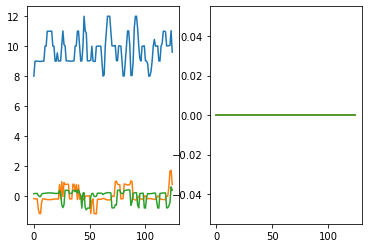

In [16]:
show_samples(X_train_oit, y_train, n=1, is_random=False)

## Data Exploration

In [17]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['no_activity' 'walk' 'stairsup' 'stairsdown' 'bike']


Fraction of samples per label

In [18]:
print(y_df.groupby(["label"])["label"].count() / y_df["label"].count())

label
bike           0.139714
no_activity    0.368941
stairsdown     0.118155
stairsup       0.151445
walk           0.221745
Name: label, dtype: float64


Fraction of samples per user

In [19]:
print(y_df.groupby(["user"])["user"].count() / y_df["user"].count())

user
a    0.113949
b    0.115366
c    0.101465
d    0.114480
e    0.120413
f    0.094781
g    0.113285
h    0.107353
i    0.118907
Name: user, dtype: float64


Fraction of samples per model

In [20]:
print(y_df.groupby(["model"])["model"].count() / y_df["model"].count())

model
nexus4_1    0.198105
nexus4_2    0.211342
s3_1        0.187171
s3_2        0.206029
s3mini_1    0.190137
s3mini_2    0.007216
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [21]:
y_df_i = y_df.loc[y_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

2686
label
bike           0.164557
no_activity    0.380491
stairsdown     0.119509
stairsup       0.099032
walk           0.236411
Name: label, dtype: float64


## Model (autoencoder)

X[0]: bike


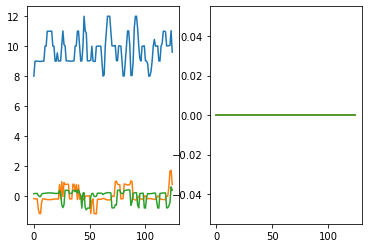

In [22]:
show_samples(X_train_oit, y_train, n=1, is_random=False)

In [23]:
DATA_SHAPE = X_train_oit.shape[1:]
CODE_SIZE=60

In [24]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)

    #X = layers.Conv1D(3)(inputs)
    #X = layers.BatchNormalization()(X)
    #X = layers.MaxPool1D(2)(X)
    #X = layers.Activation("tanh")(X)
    
    X = layers.Flatten()(inputs)
    outputs = layers.Dense(code_size, activation="sigmoid")(X)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))
    X = layers.Dense(np.prod(data_shape), activation=None)(inputs)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [26]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [28]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=100
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train_oit, y=X_train_oit, 
    epochs=epochs, 
    validation_data=(X_test_oit, X_test_oit), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/100
137/137 [==============================] - 0s 3ms/step - loss: 8.2603 - val_loss: 3.1765
Epoch 2/100
137/137 [==============================] - 0s 2ms/step - loss: 2.0855 - val_loss: 1.4404
Epoch 3/100
137/137 [==============================] - 0s 2ms/step - loss: 1.5429 - val_loss: 1.3076
Epoch 4/100
137/137 [==============================] - 0s 2ms/step - loss: 1.4770 - val_loss: 1.2241
Epoch 5/100
137/137 [==============================] - 0s 2ms/step - loss: 1.4208 - val_loss: 1.1598
Epoch 6/100
137/137 [==============================] - 0s 2ms/step - loss: 1.3604 - val_loss: 1.1042
Epoch 7/100
137/137 [==============================] - 0s 2ms/step - loss: 1.2803 - val_loss: 1.0407
Epoch 8/100
137/137 [==============================] - 0s 2ms/step - loss: 1.2125 - val_loss: 1.0131
Epoch 9/100
137/137 [==============================] - 0s 2ms/step - loss: 1.1749 - val_loss: 0.9962
Epoch 10/100
137/137 [==============================] - 0s 2ms/step - loss: 1.1488 - val_lo

In [29]:
encoder.save("encoder.h5")

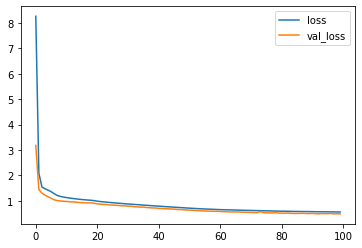

In [30]:
show_loss(history)

In [31]:
show_mse(autoencoder, X_test_oit)

MSE = 0.48674729466438293


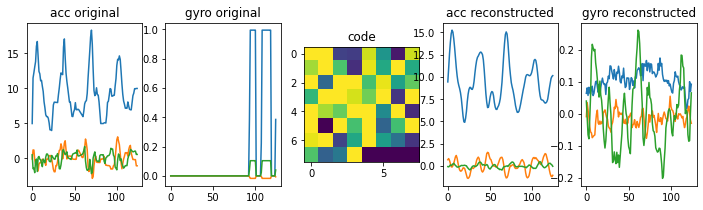

In [32]:
show_reconstructed_signals(X_test_oit, encoder, decoder, n=1)

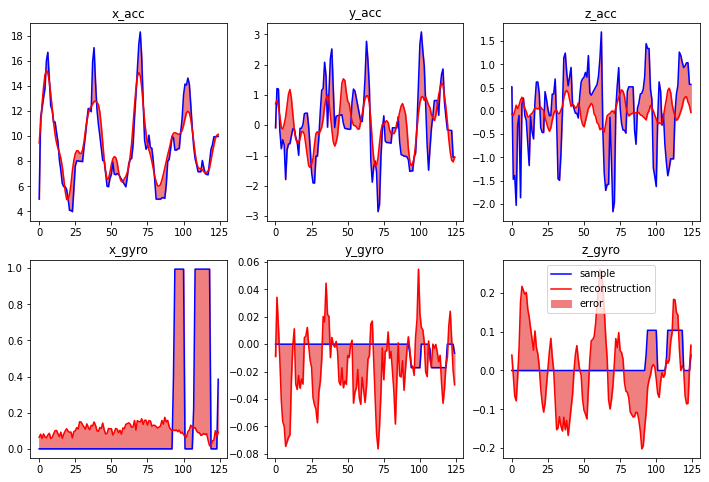

In [33]:
show_reconstruction_errors(X_test_oit, encoder, decoder, n=1)

## KNN classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train_oit)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = num_classes
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [35]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [36]:
print("X_test_oit[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test_oit[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test_oit[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = stairsdown	 stairsdown   	 with probs [0. 0. 1. 0. 0.]
X_test[1] = stairsup	 stairsup   	 with probs [0.  0.  0.  0.6 0.4]
X_test[2] = bike	 no_activity   	 with probs [0.4 0.6 0.  0.  0. ]
X_test[3] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[4] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[5] = walk	 stairsup   	 with probs [0.  0.  0.  0.8 0.2]
X_test[6] = stairsdown	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[7] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[8] = bike	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[9] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[10] = no_activity	 no_activity   	 with probs [0.2 0.8 0.  0.  0. ]
X_test[11] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[12] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[13] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[14

In [37]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test_oit)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.57      0.58      0.58       819
 no_activity       0.83      1.00      0.91      1950
  stairsdown       0.78      0.60      0.68       613
    stairsup       0.35      0.32      0.33       623
        walk       0.87      0.70      0.78      1106

    accuracy                           0.74      5111
   macro avg       0.68      0.64      0.65      5111
weighted avg       0.73      0.74      0.73      5111



## KMeans classifier

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
le.fit(y_test)

# train
codes = encoder.predict(X_train_oit)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(codes)

# evaluate 
codes = encoder.predict(X_test_oit)

y_true = y_test
y_pred = le.inverse_transform(kmeans.predict(codes))

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.08      0.05      0.06       819
 no_activity       0.05      0.03      0.04      1950
  stairsdown       0.00      0.00      0.00       613
    stairsup       0.09      0.42      0.15       623
        walk       0.00      0.00      0.00      1106

    accuracy                           0.07      5111
   macro avg       0.04      0.10      0.05      5111
weighted avg       0.04      0.07      0.04      5111



## NN classifier

In [39]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.4)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)

codes_train = encoder.predict(X_train_oit)
codes_test = encoder.predict(X_test_oit)

nn_model = build_nn(CODE_SIZE)

adam_optimizer = tf.keras.optimizers.Adam()
loss_funct = tf.keras.losses.CategoricalCrossentropy()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
callbacks = [early_stopping_callback]

nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics = ["accuracy"])
nn_model.summary()

history = nn_model.fit(x=codes_train, y=y_train_hot,
    epochs=50,
    validation_data=(codes_test, y_test_hot), 
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 6,605
Trainable params: 6,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
547/547 [==============================] - 1s 1ms/step - loss: 1.3228 - accuracy: 0.4829 - val_loss: 1.1239 - val_accuracy: 0.5625
Epoch 2/50
547/547 [==============================] - 1s 1ms/step - loss: 1.0195 - accuracy: 0.6006 - val_lo

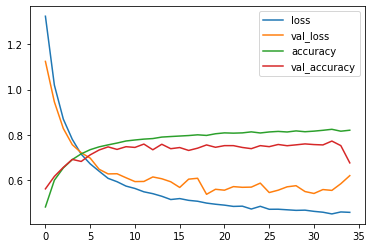

In [40]:
show_loss(history)